# Main

This file contains everything you need to run the model. This requires already be in csv format in the "data/clean" directory.

You must run everything in "scripts" before running this file.

In [1]:
import os
import numpy as np
import pandas as pd

## Visualize paths

A little janky, but works.

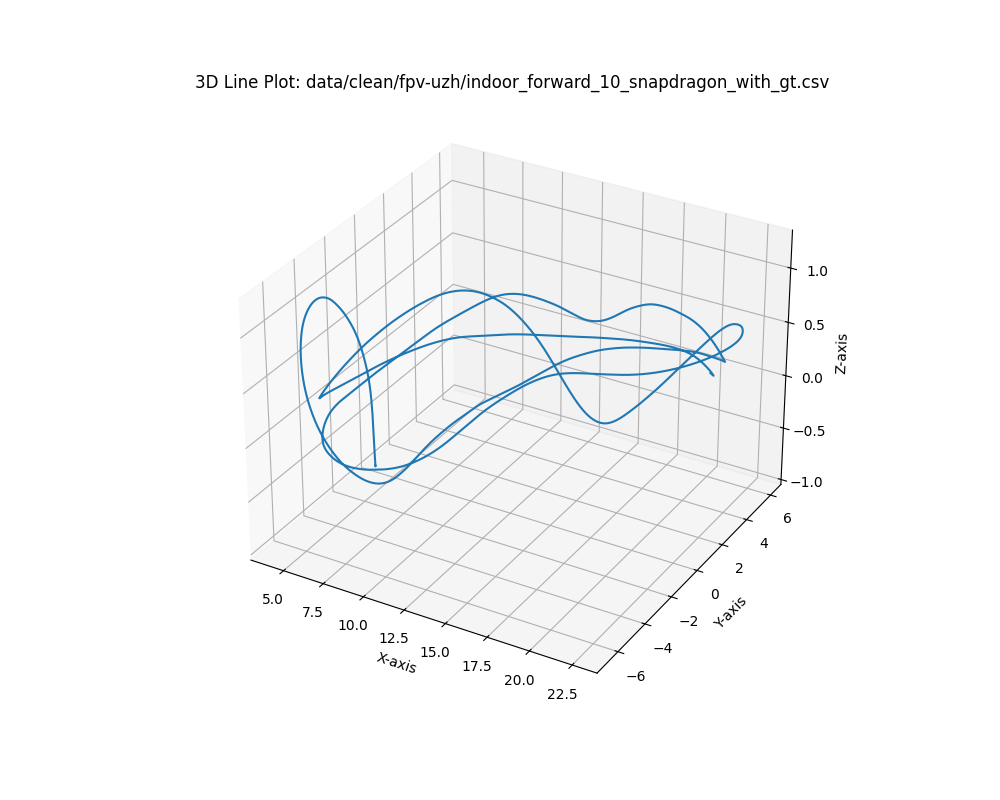

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output
import glob
import os

%matplotlib widget

def create_interactive_3d_plot(root="data/clean"):

    dirs = os.listdir(root)

    directory_dropdown = widgets.Dropdown(
        options=dirs,
        description="Select Directory:",
        disabled=False
    )

    # Get a list of all CSV files in the specified directory
    csv_files = os.listdir(os.path.join(root, dirs[0]))
    if not csv_files:
        print(f"No CSV files found in {os.path.abspath(root)}")
        return

    # Create a dropdown widget for file selection
    file_dropdown = widgets.Dropdown(
        options=csv_files,
        description="Select CSV:",
        disabled=False,
    )

    output_area = widgets.Output()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    def update_files(change):
        with output_area:
            clear_output(wait=True)
            selected_directory = change["new"]
            new_files = os.listdir(os.path.join(root, selected_directory))

            if new_files:
                file_dropdown.options = new_files
                file_dropdown.disabled = False
            else:
                file_dropdown.options = ["No files"]
                file_dropdown.disabled = True

    def update_plot(change):
        with output_area:
            clear_output(wait=True)
            selected_file = change["new"]
            selected_directory = directory_dropdown.value
            
            file_path = os.path.join(root, selected_directory, selected_file)
            ax.clear()
            
            try:
                df = pd.read_csv(file_path)

                if "tx" not in df.columns or "ty" not in df.columns or "tz" not in df.columns:
                    ax.clear() # Clear any previous plot or error message
                    ax.text2D(0.5, 0.5, f"Error: '{file_path}' missing 'tx', 'ty', or 'tz' columns.", # type: ignore
                            transform=ax.transAxes, ha="center")
                    fig.canvas.draw_idle()
                    return

                ax.clear()

                line = ax.plot(df["tx"], df["ty"], df["tz"])[0]

                # Update labels and title
                ax.set_xlabel("X-axis")
                ax.set_ylabel("Y-axis")
                ax.set_zlabel("Z-axis")
                ax.set_title(f"3D Line Plot: {file_path}")

                # Ensure data limits are set correctly for the new data
                x_min, x_max = df["tx"].min(), df["tx"].max()
                y_min, y_max = df["ty"].min(), df["ty"].max()
                z_min, z_max = df["tz"].min(), df["tz"].max()

                # Add a small buffer to the limits for better visualization
                x_buffer = (x_max - x_min) * 0.05
                y_buffer = (y_max - y_min) * 0.05
                z_buffer = (z_max - z_min) * 0.05

                ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
                ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
                ax.set_zlim(z_min - z_buffer, z_max + z_buffer)

                
            except Exception as e:
                ax.clear() # Clear any previous plot or error message
                ax.text2D(0.5, 0.5, f"Error loading or plotting {file_path}: {e}", # type: ignore
                        transform=ax.transAxes, ha="center")
                fig.canvas.draw_idle()



    directory_dropdown.observe(update_files, names="value")
    file_dropdown.observe(update_plot, names="value")

    display(widgets.VBox([directory_dropdown, file_dropdown, output_area]))

    update_files({"new": directory_dropdown.value})
    update_plot({"new": file_dropdown.value})
    
    plt.show()

create_interactive_3d_plot(root="data/clean")

## Resample the data and derive velocity

The fpv-uzh and mid-air datasets have different sample rates and formats. This code is meant to resample everything to 10hz (sample time = 0.1sec). This function also removes the rotation data from the fpv-uzh dataset.

The sample rate is can actually be thought of as a hyperparameter for our model. For now, we are following the VECTOR GRU paper.

The model can either be trained on positional or velocity data.

In [ ]:
def resample(df: pd.DataFrame, sampling_time: float):
    df = df.sort_values("timestamp")
    new_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), sampling_time)
    
    # Interpolate tx, ty, tz values at the new timestamps
    new_tx = np.interp(new_timestamps, df['timestamp'], df['tx'])
    new_ty = np.interp(new_timestamps, df['timestamp'], df['ty'])
    new_tz = np.interp(new_timestamps, df['timestamp'], df['tz'])
    
    # Create a new DataFrame with the resampled trajectory
    df_resampled = pd.DataFrame({
        'timestamp': new_timestamps,
        'tx': new_tx,
        'ty': new_ty,
        'tz': new_tz
    })
    
    return df_resampled

def velocity(df: pd.DataFrame):
    out = pd.DataFrame(columns=["timestamp", "vx", "vy", "vz"])
    dt = df["timestamp"].diff()

    out["timestamp"] = df["timestamp"]
    out["vx"] = df["tx"].diff() / dt
    out["vy"] = df["ty"].diff() / dt
    out["vz"] = df["tz"].diff() / dt

    return out.iloc[1:]

# resample everything in "data/clean" and save positional and velocity data.
out_path_pos = "data/position/raw"
out_path_vel = "data/velocity/raw"
os.makedirs(out_path_pos, exist_ok=True)
os.makedirs(out_path_vel, exist_ok=True)

def walk_and_process(root="data/clean"):
    for dirname in os.listdir(root):
        os.makedirs(os.path.join(out_path_pos, dirname), exist_ok=True)
        os.makedirs(os.path.join(out_path_vel, dirname), exist_ok=True)
        for filename in os.listdir(os.path.join(root, dirname)):
            df = pd.read_csv(os.path.join(root, dirname, filename))
            res = resample(df, 0.1)
            vel = velocity(res)
            res.to_csv(os.path.join(out_path_pos, dirname, filename))
            vel.to_csv(os.path.join(out_path_vel, dirname, filename))
    
 
walk_and_process()

## Normalize Data

We will use max normalization and statistical whitening

## Split data

5-fold stratified cross validation. Must be stratified because training data comes from different distributions.